In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from model import *
from utils import *
import pickle as pkl
import os
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set(style='whitegrid')
device = torch.device("cuda")

In [2]:
def sample_batch_singindex(B, d_in, device="cuda"):
    x = torch.randn(B, d_in, device=device) / math.sqrt(d_in)
    y = f_hermite(x @ teacher_weights).reshape(-1, 1)
    return x, y

def train_model(d_in, widths, B, T, lrs, sample_batch_fn, device="cuda", type="mup"):
    train_losses = {w: {lr:[] for lr in lrs} for w in widths}
    loss_fn = nn.MSELoss()
    for width in widths:
        for lr in lrs:
            has_nan = False
            model = MLP2Hidden(d_in, width, 1).to(device)
            if type == "mup":
                model.init_weights_mup()
                optimizer = model.init_optimizer_mup(lr, optimizer="Adam")
            elif type == "ntk":
                model.init_weights_ntk()
                optimizer = model.init_optimizer_ntk(lr)
            else:
                raise ValueError("Invalid type")
            model.train()
            for step in range(T):
                if has_nan:
                    train_losses[width][lr].append(np.nan)
                    continue
                x, y_true = sample_batch_fn(B, d_in, device=device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y_true)
                loss.backward()
                optimizer.step()
                train_losses[width][lr].append(loss.item())
                if torch.isnan(loss):
                    has_nan = True
                if step % 2000 == 0 and step > 100:
                    print(f"Step {step} for width {width}, lr {lr}, Loss: {np.mean(train_losses[width][lr][-1000:])}")
            if has_nan:
                print(f"Model {width} with lr {lr} has NaN loss")
    return train_losses

In [3]:
d_in = 16
def f_hermite(x): return (x**3 - 3*x)/math.sqrt(6)
torch.manual_seed(32)
teacher_weights = torch.randn(d_in, 1, device=device)
teacher_weights /= teacher_weights.norm()
teacher_weights *= math.sqrt(d_in)

Step 2000 for width 512, lr 0.001, Loss: 0.8188384290635585
Step 4000 for width 512, lr 0.001, Loss: 0.4104724417179823
Step 6000 for width 512, lr 0.001, Loss: 0.26368241626769306
Step 8000 for width 512, lr 0.001, Loss: 0.20459432815015316
Step 10000 for width 512, lr 0.001, Loss: 0.1654819437712431
Step 12000 for width 512, lr 0.001, Loss: 0.13945811308175327
Step 14000 for width 512, lr 0.001, Loss: 0.11619699186459184
Step 16000 for width 512, lr 0.001, Loss: 0.10565405508130789
Step 18000 for width 512, lr 0.001, Loss: 0.08676314835436642
Step 20000 for width 512, lr 0.001, Loss: 0.07455577109754086
Step 22000 for width 512, lr 0.001, Loss: 0.06502731357887387
Step 24000 for width 512, lr 0.001, Loss: 0.05482933765463531
Step 26000 for width 512, lr 0.001, Loss: 0.04447246737405658
Step 28000 for width 512, lr 0.001, Loss: 0.03805328517220914
Step 30000 for width 512, lr 0.001, Loss: 0.0351105756405741
Step 32000 for width 512, lr 0.001, Loss: 0.03142575375922024
Step 34000 for w

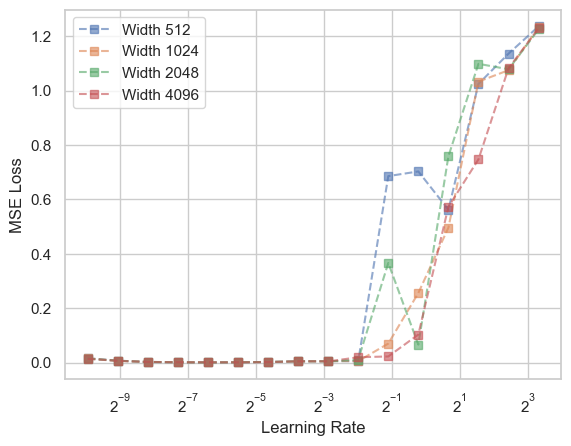

In [4]:
widths = [512, 1024, 2048, 4096]
lrs = np.logspace(-3.0, 1.0, 16)
B = 2048
T = 50001
type = "mup"
train_losses_mup = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][-3000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()

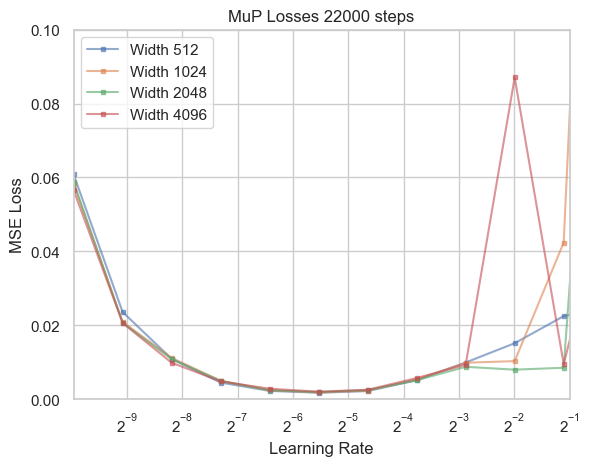

In [34]:
lrs = np.logspace(-3.0, 1.0, 16)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_mup[width][lr][20000:24000]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=3, label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.title("MuP Losses 22000 steps")
plt.ylim(0.0, 0.1)
plt.xlim(0.001, 0.5)
plt.legend()

Step 2000 for width 512, lr 0.0031622776601683794, Loss: 1.0599801449775696
Step 4000 for width 512, lr 0.0031622776601683794, Loss: 1.036026556313038
Step 6000 for width 512, lr 0.0031622776601683794, Loss: 1.027313456594944
Step 8000 for width 512, lr 0.0031622776601683794, Loss: 1.0169084014892578
Step 10000 for width 512, lr 0.0031622776601683794, Loss: 1.014147891163826
Step 12000 for width 512, lr 0.0031622776601683794, Loss: 1.014902937233448
Step 14000 for width 512, lr 0.0031622776601683794, Loss: 1.0105704075694084
Step 16000 for width 512, lr 0.0031622776601683794, Loss: 1.0102978578209878
Step 18000 for width 512, lr 0.0031622776601683794, Loss: 0.9947537121772766
Step 20000 for width 512, lr 0.0031622776601683794, Loss: 0.9979395428299904
Step 22000 for width 512, lr 0.0031622776601683794, Loss: 0.9952806071043014
Step 24000 for width 512, lr 0.0031622776601683794, Loss: 0.9960375161170959
Step 2000 for width 512, lr 0.005580417174769964, Loss: 1.0285707116127014
Step 4000

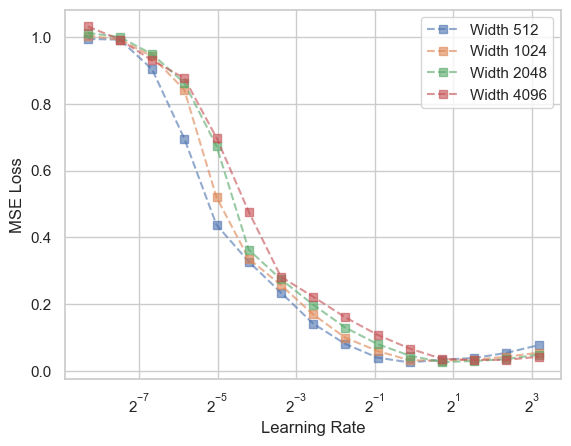

In [9]:
widths = [512, 1024, 2048, 4096, ]
lrs = np.logspace(-2.5, 1.2, 16)
B = 2048
T = 24001
type = "ntk"
train_losses_ntk = train_model(d_in, widths, B, T, lrs, sample_batch_singindex, device, type)
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_ntk[width][lr][-3000:]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.legend()

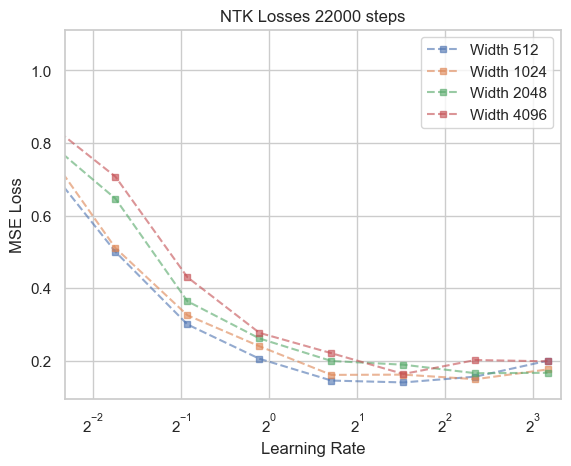

In [47]:
lrs = np.logspace(-2.5, 1.2, 16)
S=3000
for idx, width in enumerate(widths):
        t_losses = [np.mean(train_losses_ntk[width][lr][S-1000:S]) for lr in lrs ]
        plt.plot(lrs , t_losses, marker='s', alpha=0.6, markersize=4.5, linestyle='--', label=f'Width {width}')
plt.xscale('log', base=2)
plt.xlabel("Learning Rate")
plt.ylabel("MSE Loss")
plt.xlim(0.2, 10.00)
#plt.ylim(0.0, 0.2)
plt.title("NTK Losses 22000 steps")
plt.legend()

In [36]:
pkl.dump(train_losses_ntk, open("assets_singleindex/train_losses_ntk.pkl", "wb"))
pkl.dump(train_losses_mup, open("assets_singleindex/train_losses_mup.pkl", "wb"))